# IED sequence detection

This notebook detects IEDs and groups them into sequences. This includes:
* Loading an EDF file containing the recordings and keeping a defined subset of all channels.
* Running an IED detection algorithm.
* Grouping IEDs into sequences across channels.
* Doing a basic EDA by producing some plots.

In [1]:
import mne
import scipy
import scipy.io
from scipy import signal
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import math
import pyedflib
from tqdm import tqdm

matplotlib.rcParams['figure.figsize'] = (20, 10)
mne.set_log_level('WARNING')

%run DetectSpike_SEEG.py

Open the file

In [73]:
# file_name = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'
file_name = 'Data/TrialPatientArRa/X~ X_2fc7b4bb-d0f1-45b1-b60d-0ec24a942259.EDF'

f = pyedflib.EdfReader(file_name)

Define file specific parameters

In [82]:
freq = 2048
ref_chan = 'EEG L6'

Get channels and number of channels

In [77]:
num_chans = f.signals_in_file  # change to valid_channels.shape[0]
signal_labels = f.getSignalLabels()

Get list of channels to use from channels.mat

In [5]:
# Load file containing suitable channels and convert to list
mat = scipy.io.loadmat('Data/TrialPatientArRa/channels.mat')
valid_channels = [channel[0] for channel in mat['channels'][:, 0]]

# valid_channels = signal_labels

Segment the data into blocks of length mins_to_process and detect IEDs in each.

In [84]:
# In minutes
mins_to_process=20

# Time points
M = f.getNSamples()[0]

SpikeIds = []
ChanIds = []

# Duration of recording in seconds
NumSecs = M / freq
Blocks = math.floor(NumSecs / (mins_to_process * 60))

# TODO do we loop through final iteration correctly? Depends on Blocks calculation 
# Iterate through each block of mins_to_process minutes
for current_block in tqdm(range(Blocks)):

    data_block = np.zeros((len(valid_channels), freq * 60 * mins_to_process))
    
    reference = f.readSignal(signal_labels.index(ref_chan), \
                             start = current_block * freq * 60 * mins_to_process, \
                             n = freq * 60 * mins_to_process)

    # Populate area of data for the current block across all channels
    for i, chan in enumerate(valid_channels):

        data_block[i, :] = f.readSignal(signal_labels.index(chan), \
                                        start = current_block * freq * 60 * mins_to_process, \
                                        n = freq * 60 * mins_to_process) - reference

    # Detect IEDs in current block across all chanels
    SpikeIndex, ChanId, _ = DetectSpikes(data_block, freq, DetThresholds=[7, 7, 300, 10, 10])
    
    # Add to list across all blocks, corrected for index of block start
    SpikeIds.append(SpikeIndex + current_block * freq * 60 * mins_to_process)
    ChanIds.append(ChanId)

# Convert to numpy arrays
SpikeIds = np.concatenate(SpikeIds, axis=0)
ChanIds = np.concatenate(ChanIds, axis=0)

100%|██████████| 3/3 [04:30<00:00, 90.30s/it]


Plot histogram of inter-IED intervals.

Text(0.5, 6.79999999999999, 'Time (s)')

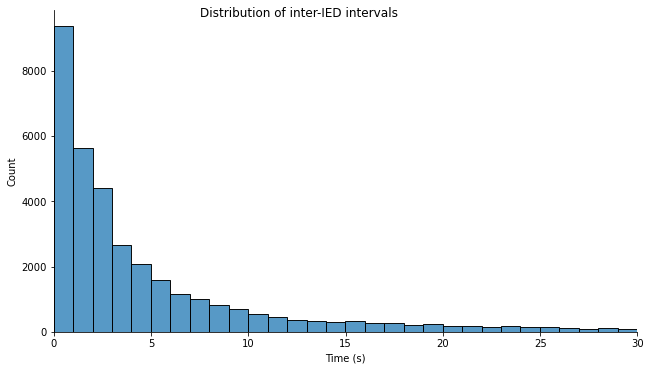

In [86]:
# Difference in time between IEDs
diffs = np.zeros((1))
for channel in np.unique(ChanIds):
    diffs = np.append(diffs, np.diff(SpikeIds[ChanIds == channel]))

# Only keep intervals < 30s
filtered_diffs = diffs[diffs / freq < 30]

# Plot using histogram
g = sns.displot(filtered_diffs / freq, bins=30)

# Alternatively use kde plot
# g = sns.displot(filtered_diffs / freq, kind='kde')

g.fig.set_size_inches(10,5)
g.set(xlim=(0, 30))
# g.ax.set_yscale('log')
g.fig.suptitle('Distribution of inter-IED intervals')
plt.xlabel('Time (s)')

Detect IED sequences from individual IED spikes. If an IED is within 50ms of the start of the current sequence, or 15ms from the last added spike in the sequence, it's added to the sequence.

In [87]:
spikes, chans = SpikeIds.copy(), ChanIds.copy()

spikes_argsort = np.argsort(spikes)
spikes = list(spikes[spikes_argsort])
chans = list(chans[spikes_argsort])

# 50ms and 15ms in indices (using known frequency)
fifty_ms = int(round(freq * 0.05))
fifteen_ms = int(round(freq * 0.015))

# Lists for all sequences, one for spike indices and one for channels
all_seq_spikes = []
all_seq_chans = []

# While there are unprocessed spikes 
while len(spikes) > 0:
    
    # Start a list with the leading spike
    seq_spikes = [spikes.pop(0)]
    seq_chans = [chans.pop(0)]
    
    curr_spike = seq_spikes[0]
    
    # For remaining spikes
    for spike in spikes:
        # If spike is within 15ms of last spike in sequence or 50ms of first
        if spike - seq_spikes[0] <= fifty_ms or spike - curr_spike <= fifteen_ms:
            # Then add to sequence
            curr_spike = spike
            
            seq_spikes.append(spikes.pop(0))
            seq_chans.append(chans.pop(0))
            
        # When no more eligible spikes, move to next sequence
        else:
            break
    
    # Add processed sequence to list of sequences
    all_seq_spikes.append(seq_spikes)
    all_seq_chans.append(seq_chans)

Work out the most common routes within IED sequences and display the top 20.

In [88]:
# If a sequence is A -> B -> C, count A -> B as one connection and B -> C as another.
starts_list = [chan[:-1] for chan in all_seq_chans if len(chan) >= 2]
ends_list = [chan[1:] for chan in all_seq_chans if len(chan) >= 2]

pairs = []

for starts, ends in zip(starts_list, ends_list):
    for start, end in zip(starts, ends):
        pairs.append([int(start), int(end)])

unique, counts = np.unique(pairs, return_counts=True, axis=0)

sorted_counts = np.flip(np.argsort(counts))
counts = counts[sorted_counts]
unique = unique[sorted_counts]

for u, c in zip(unique, counts):
    print(c, valid_channels[u[0]], '->', valid_channels[u[1]])

810 EEG J1 -> EEG J2
575 EEG I3 -> EEG I4
502 EEG I2 -> EEG I3
490 EEG I4 -> EEG I5
451 EEG J2 -> EEG J3
432 EEG N3 -> EEG N2
344 EEG I3 -> EEG I2
310 EEG J3 -> EEG J4
213 EEG I4 -> EEG I3
212 EEG J11 -> EEG J12
212 EEG N8 -> EEG N9
205 EEG N2 -> EEG N3
201 EEG J11 -> EEG J10
173 EEG J7 -> EEG J6
173 EEG N9 -> EEG N8
168 EEG J12 -> EEG J11
155 EEG J10 -> EEG J11
139 EEG J10 -> EEG J9
134 EEG I5 -> EEG I4
128 EEG J5 -> EEG J6
122 EEG N9 -> EEG N10
121 EEG J4 -> EEG J5
111 EEG E2 -> EEG E3
106 EEG E3 -> EEG O15
106 EEG I2 -> EEG I4
104 EEG J1 -> EEG N3
104 EEG J6 -> EEG J7
99 EEG J5 -> EEG J7
97 EEG J1 -> EEG J11
96 EEG N3 -> EEG I3
95 EEG I3 -> EEG I5
94 EEG E3 -> EEG E2
89 EEG O15 -> EEG E2
86 EEG I1 -> EEG N3
82 EEG I4 -> EEG I2
82 EEG N3 -> EEG I2
81 EEG C8 -> EEG C7
80 EEG I5 -> EEG I6
79 EEG J9 -> EEG J7
77 EEG H3 -> EEG H2
76 EEG I2 -> EEG I1
70 EEG O15 -> EEG E3
70 EEG N2 -> EEG I3
69 EEG N2 -> EEG I2
69 EEG J6 -> EEG J8
65 EEG H2 -> EEG H3
64 EEG E2 -> EEG O15
62 EEG J11 -> EEG 

6 EEG C10 -> EEG C7
6 EEG J11 -> EEG K1
6 EEG N1 -> EEG I3
6 EEG J11 -> EEG J6
6 EEG I2 -> EEG H2
6 EEG I1 -> EEG C8
6 EEG Q3 -> EEG B9
6 EEG N9 -> EEG N5
6 EEG N4 -> EEG H2
6 EEG J7 -> EEG L1
6 EEG J5 -> EEG I3
6 EEG I1 -> EEG N11
6 EEG H3 -> EEG I5
6 EEG Q5 -> EEG I4
6 EEG M7 -> EEG M4
6 EEG D5 -> EEG D3
6 EEG J6 -> EEG J3
6 EEG E2 -> EEG I3
6 EEG J2 -> EEG N9
6 EEG A2 -> EEG A1
6 EEG J1 -> EEG J5
6 EEG N5 -> EEG K10
6 EEG I4 -> EEG H3
6 EEG J6 -> EEG B8
6 EEG J6 -> EEG L1
6 EEG E3 -> EEG I3
6 EEG N10 -> EEG C8
6 EEG I2 -> EEG K8
6 EEG M8 -> EEG M5
6 EEG B9 -> EEG C6
6 EEG N10 -> EEG J6
6 EEG J6 -> EEG K2
6 EEG F14 -> EEG F13
6 EEG A6 -> EEG B9
6 EEG L1 -> EEG J5
6 EEG L1 -> EEG J6
6 EEG J1 -> EEG N8
6 EEG H2 -> EEG M6
6 EEG P1 -> EEG P2
6 EEG J2 -> EEG N5
6 EEG C6 -> EEG A6
6 EEG A6 -> EEG C6
6 EEG M5 -> EEG Q5
6 EEG H2 -> EEG M4
6 EEG N8 -> EEG J7
6 EEG N9 -> EEG I5
6 EEG N8 -> EEG I3
6 EEG B8 -> EEG C6
5 EEG N10 -> EEG J9
5 EEG J1 -> EEG N6
5 EEG N10 -> EEG N2
5 EEG N9 -> EEG C10


2 EEG L2 -> EEG I5
2 EEG L2 -> EEG I4
2 EEG L3 -> EEG L1
2 EEG M4 -> EEG G8
2 EEG N8 -> EEG C6
2 EEG N8 -> EEG C8
2 EEG N6 -> EEG J7
2 EEG H2 -> EEG E3
2 EEG N6 -> EEG K10
2 EEG N6 -> EEG M7
2 EEG M4 -> EEG I2
2 EEG N8 -> EEG D3
2 EEG G9 -> EEG E8
2 EEG H2 -> EEG I5
2 EEG G8 -> EEG M8
2 EEG G8 -> EEG D4
2 EEG H4 -> EEG I2
2 EEG G6 -> EEG H5
2 EEG G7 -> EEG H2
2 EEG H8 -> EEG H6
2 EEG N8 -> EEG M8
2 EEG M7 -> EEG J1
2 EEG N1 -> EEG N9
2 EEG N1 -> EEG N10
2 EEG M7 -> EEG K10
2 EEG N1 -> EEG I5
2 EEG M7 -> EEG L1
2 EEG N1 -> EEG J1
2 EEG N8 -> EEG K7
2 EEG N1 -> EEG J2
2 EEG N1 -> EEG J3
2 EEG K2 -> EEG K1
2 EEG N1 -> EEG J12
2 EEG K2 -> EEG J2
2 EEG G6 -> EEG N4
2 EEG N8 -> EEG K9
2 EEG H7 -> EEG M5
2 EEG H7 -> EEG H2
2 EEG H4 -> EEG I3
2 EEG H6 -> EEG M7
2 EEG O15 -> EEG N2
2 EEG H4 -> EEG M4
2 EEG G8 -> EEG E4
2 EEG H4 -> EEG M6
2 EEG H4 -> EEG M7
2 EEG M4 -> EEG L2
2 EEG N6 -> EEG C8
2 EEG N6 -> EEG E2
2 EEG G8 -> EEG Q2
2 EEG N6 -> EEG Q5
2 EEG M8 -> EEG J10
2 EEG M8 -> EEG M8
2 EEG 

1 EEG J2 -> EEG O12
1 EEG J2 -> EEG A7
1 EEG J2 -> EEG A6
1 EEG J2 -> EEG B11
1 EEG J2 -> EEG B10
1 EEG J2 -> EEG B9
1 EEG J2 -> EEG D6
1 EEG J2 -> EEG D4
1 EEG J2 -> EEG C10
1 EEG J2 -> EEG E2
1 EEG Q2 -> EEG C9
1 EEG Q2 -> EEG C10
1 EEG Q2 -> EEG D2
1 EEG Q2 -> EEG D5
1 EEG J6 -> EEG C9
1 EEG J6 -> EEG A7
1 EEG Q2 -> EEG A5
1 EEG J11 -> EEG O1
1 EEG J11 -> EEG D3
1 EEG J11 -> EEG E6
1 EEG J11 -> EEG E3
1 EEG J11 -> EEG E2
1 EEG Q1 -> EEG E3
1 EEG Q1 -> EEG C7
1 EEG Q1 -> EEG C10
1 EEG J10 -> EEG L1
1 EEG J10 -> EEG N10
1 EEG J10 -> EEG N6
1 EEG Q1 -> EEG D2
1 EEG J10 -> EEG H8
1 EEG J10 -> EEG H2
1 EEG J10 -> EEG O15
1 EEG J10 -> EEG A2
1 EEG J10 -> EEG B9
1 EEG J10 -> EEG D6
1 EEG J10 -> EEG D2
1 EEG J10 -> EEG C6
1 EEG J10 -> EEG E2
1 EEG J10 -> EEG Q1
1 EEG J9 -> EEG J1
1 EEG J9 -> EEG K10
1 EEG J9 -> EEG K9
1 EEG J9 -> EEG I1
1 EEG J11 -> EEG B11
1 EEG J11 -> EEG O3
1 EEG J9 -> EEG G6
1 EEG J11 -> EEG O5
1 EEG Q1 -> EEG Q4
1 EEG J12 -> EEG K10
1 EEG J12 -> EEG K9
1 EEG J12 -> EEG

1 EEG B10 -> EEG I3
1 EEG B10 -> EEG K8
1 EEG B10 -> EEG K9
1 EEG B10 -> EEG J8
1 EEG B11 -> EEG Q2
1 EEG B11 -> EEG Q4
1 EEG B10 -> EEG D5
1 EEG B10 -> EEG D3
1 EEG B10 -> EEG D2
1 EEG B10 -> EEG C9
1 EEG B10 -> EEG C3
1 EEG B10 -> EEG E1
1 EEG B10 -> EEG F9
1 EEG B9 -> EEG J11
1 EEG B9 -> EEG J7
1 EEG B9 -> EEG J6
1 EEG B9 -> EEG K8
1 EEG B9 -> EEG O3
1 EEG B9 -> EEG B12
1 EEG B9 -> EEG B9
1 EEG B9 -> EEG D6
1 EEG B9 -> EEG D5
1 EEG B9 -> EEG C2
1 EEG C7 -> EEG Q4
1 EEG C6 -> EEG J9
1 EEG A2 -> EEG B4
1 EEG F11 -> EEG M4
1 EEG F11 -> EEG C7
1 EEG F11 -> EEG C8
1 EEG F11 -> EEG I1
1 EEG F11 -> EEG I2
1 EEG F11 -> EEG I3
1 EEG F11 -> EEG I5
1 EEG F11 -> EEG J1
1 EEG F11 -> EEG E3
1 EEG F12 -> EEG Q5
1 EEG F12 -> EEG F8
1 EEG F12 -> EEG F12
1 EEG F12 -> EEG E6
1 EEG F12 -> EEG C9
1 EEG F12 -> EEG I3
1 EEG F11 -> EEG E5
1 EEG F11 -> EEG E2
1 EEG F13 -> EEG F8
1 EEG F9 -> EEG N5
1 EEG F9 -> EEG Q2
1 EEG F9 -> EEG F7
1 EEG F9 -> EEG F8
1 EEG F9 -> EEG F13
1 EEG F9 -> EEG C7
1 EEG F9 -> EEG

1 EEG O1 -> EEG J1
1 EEG O2 -> EEG O14
1 EEG O1 -> EEG J2
1 EEG O1 -> EEG J4
1 EEG O1 -> EEG J7
1 EEG O1 -> EEG J12
1 EEG O2 -> EEG F2
1 EEG O2 -> EEG C1
1 EEG O4 -> EEG M5
1 EEG O5 -> EEG H4
1 EEG O1 -> EEG F3
1 EEG O15 -> EEG C6
1 EEG O14 -> EEG L1
1 EEG O15 -> EEG Q1
1 EEG O15 -> EEG Q3
1 EEG O15 -> EEG E1
1 EEG Q3 -> EEG K8
1 EEG O15 -> EEG C1
1 EEG O15 -> EEG C9
1 EEG O14 -> EEG M1
1 EEG O15 -> EEG D1
1 EEG O15 -> EEG D6
1 EEG O15 -> EEG B3
1 EEG O15 -> EEG B11
1 EEG O15 -> EEG P4
1 EEG Q3 -> EEG M6
1 EEG O14 -> EEG M7
1 EEG O14 -> EEG I3
1 EEG O5 -> EEG M6
1 EEG O13 -> EEG C6
1 EEG O6 -> EEG H7
1 EEG O12 -> EEG I3
1 EEG O12 -> EEG J2
1 EEG O12 -> EEG J11
1 EEG O12 -> EEG J12
1 EEG O13 -> EEG Q2
1 EEG O13 -> EEG C8
1 EEG O14 -> EEG N1
1 EEG O13 -> EEG A6
1 EEG O13 -> EEG N3
1 EEG O13 -> EEG N9
1 EEG O13 -> EEG I2
1 EEG O13 -> EEG J3
1 EEG O13 -> EEG J12
1 EEG O1 -> EEG E1
1 EEG A9 -> EEG H5
1 EEG H3 -> EEG N5
1 EEG A6 -> EEG Q1
1 EEG A5 -> EEG D3
1 EEG A5 -> EEG B9
1 EEG A5 -> EEG

Plot a heatmap with the frequency of each connection.

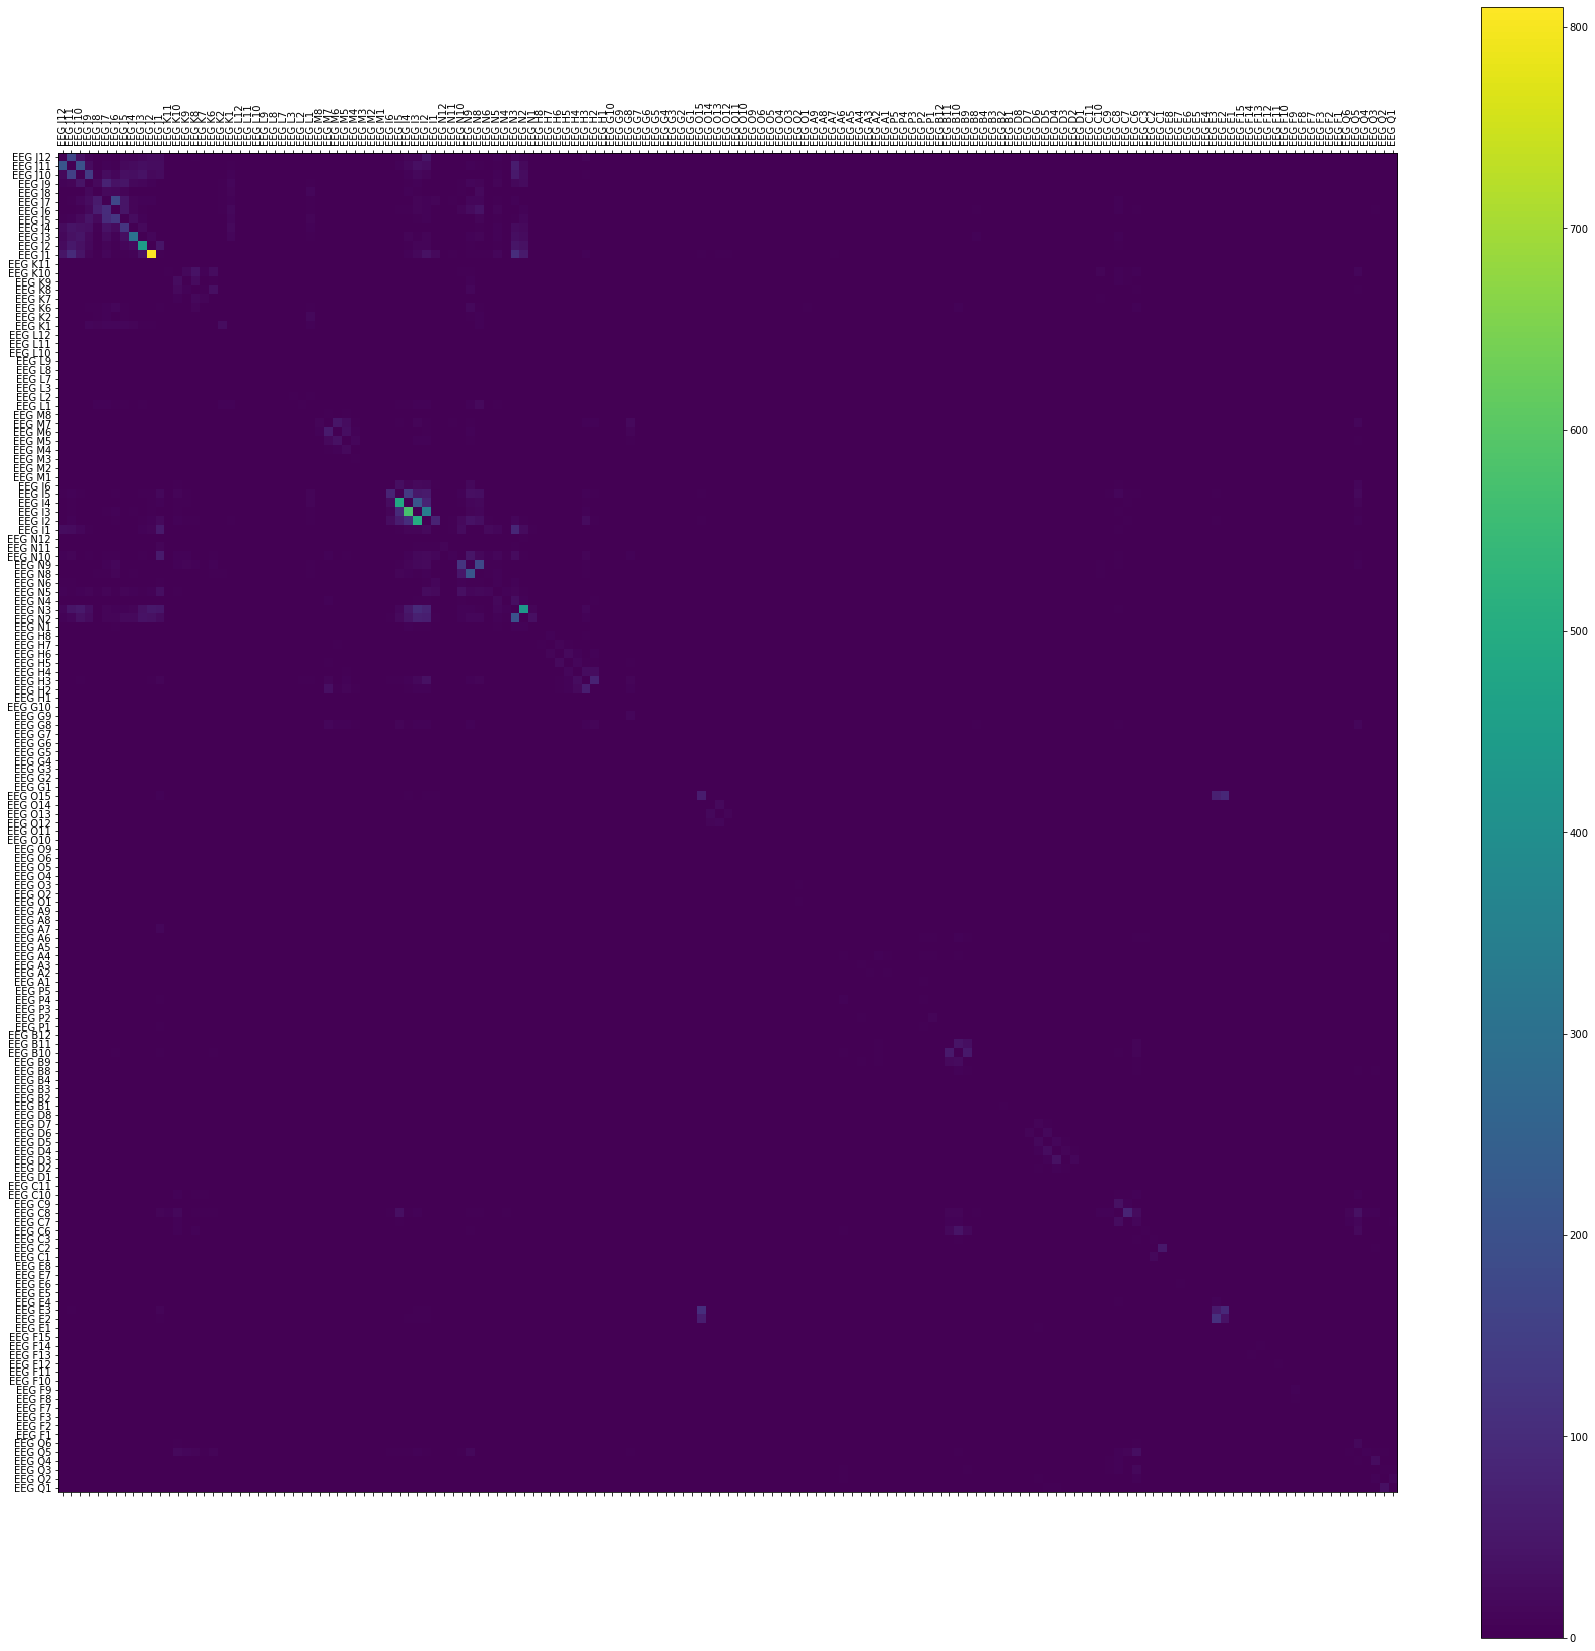

In [89]:
matplotlib.rcParams['figure.figsize'] = (30, 30)

chans = len(valid_channels)

# Produce the matrix
counts_mat = np.zeros((chans, chans))
for c, u in zip(counts, unique):
    counts_mat[u[0]][u[1]] = c

# Display as a heatmap
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(counts_mat, interpolation='nearest')
fig.colorbar(cax)

# Set ticks as appropriate
xaxis = np.arange(chans)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(valid_channels, rotation=90)
ax.set_yticklabels(valid_channels)

plt.show()

As above but just for the E electrode.

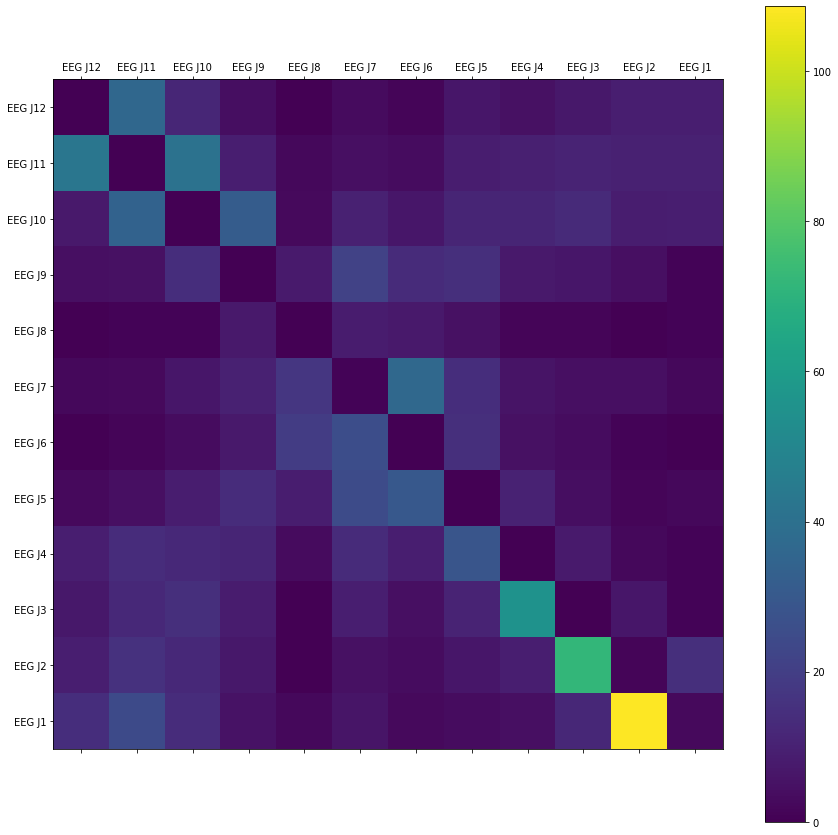

In [90]:
matplotlib.rcParams['figure.figsize'] = (15, 15)

counts_mat = np.zeros((151, 151))
for c, u in zip(counts, unique):
    counts_mat[u[0]][u[1]] = c ** 0.7

counts_mat = counts_mat[:12, :12]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(counts_mat, interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(12)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(valid_channels[:12])
ax.set_yticklabels(valid_channels[:12])

plt.show()

Create histogram for IED sequence length

[Text(0.5, 0, 'IED sequence duration (ms)')]

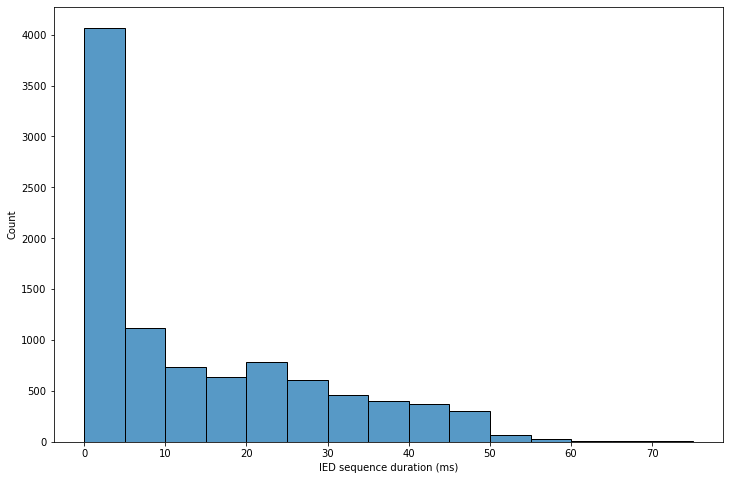

In [91]:
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Work out lengths for each sequence and convert to ms
length_list = [(1000/freq) * (spike[-1] - spike[0]) for spike in all_seq_spikes if len(spike) > 1]

ax = sns.histplot(length_list, bins=15, binrange=[0, 75])
ax.set(xlabel='IED sequence duration (ms)')

/Users/jamienorris/miniconda3/envs/diss/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jamienorris/miniconda3/envs/diss/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.04 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

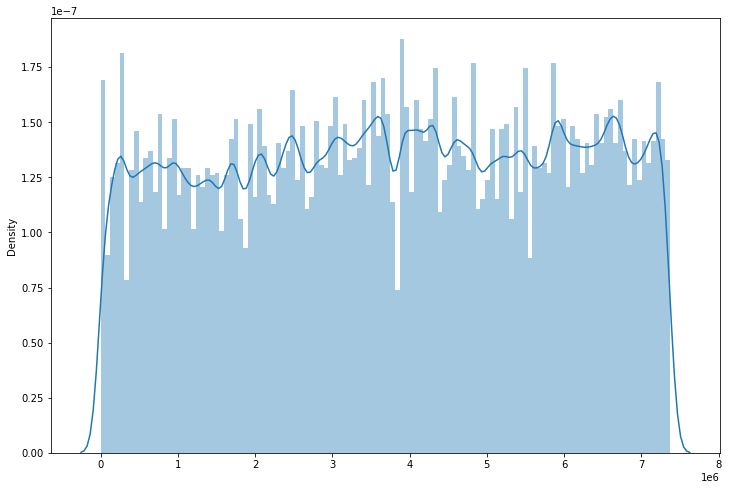

In [92]:
sequence_starts = [spike[0] for spike in all_seq_spikes]
sns.distplot(sequence_starts, bins=120, kde_kws={"bw": 0.04})#, height=10, aspect=2)

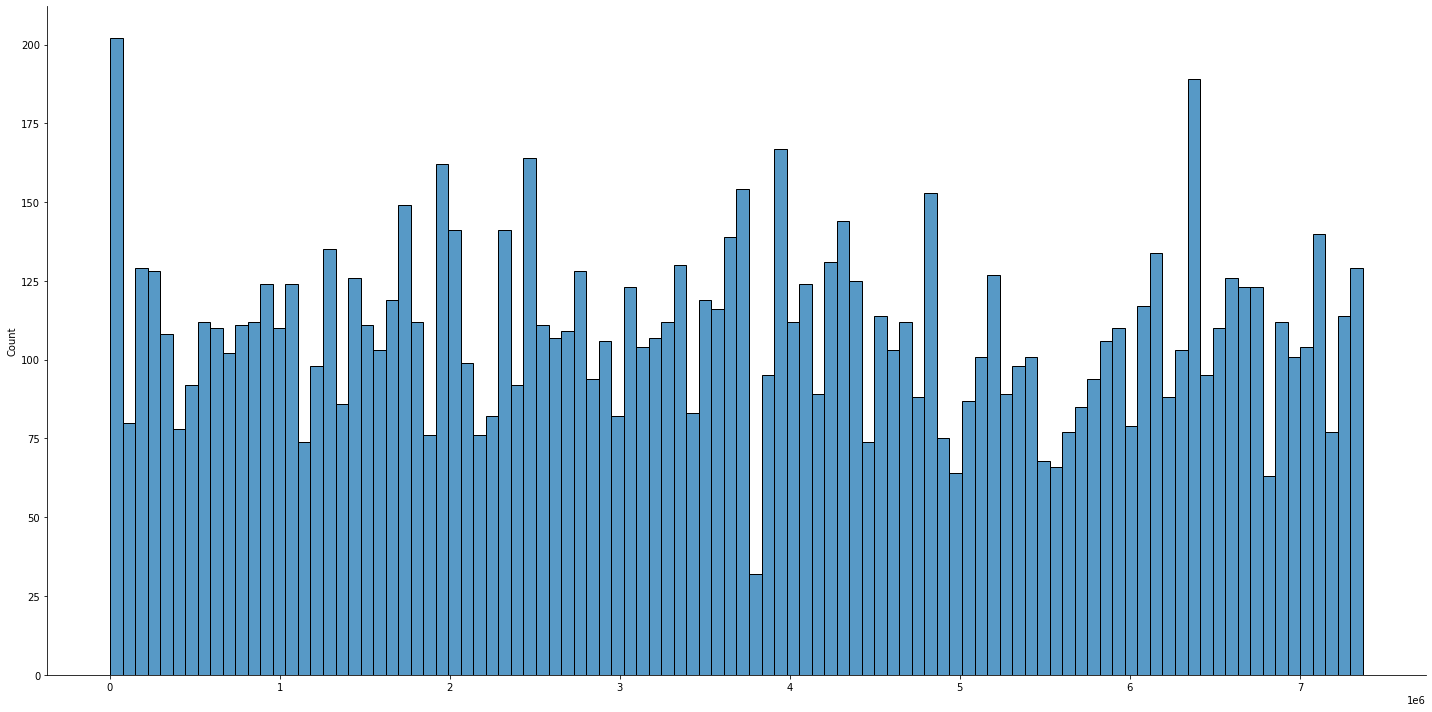

In [93]:
sns.displot(SpikeIds[ChanIds < 12], bins=100, height=10, aspect=2)

Text(0.5, 6.79999999999999, 'Time (s)')

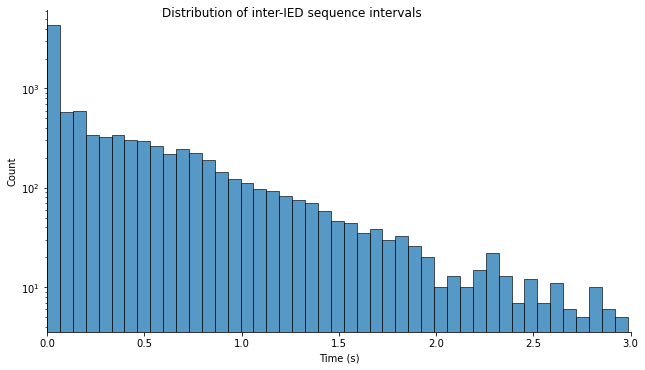

In [94]:
# Difference in time between IEDs
diffs = np.diff(np.array([spikes[0] for spikes in all_seq_spikes if len(spikes) > 1]))

# Only keep intervals < 3s
filtered_diffs = diffs[diffs / freq < 3]

# Plot using histogram
g = sns.displot(filtered_diffs / 2048, bins=45)

g.fig.suptitle('Distribution of inter-IED sequence intervals')
g.fig.set_size_inches(10,5)
g.set(xlim=(0, 3))
g.ax.set_yscale('log')
plt.xlabel('Time (s)')

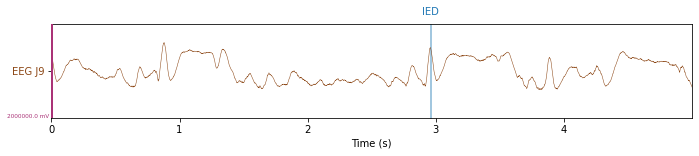

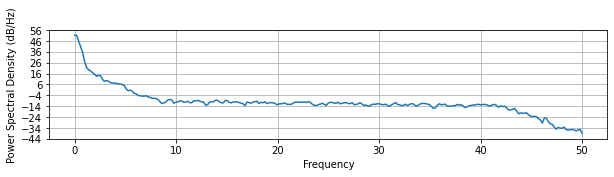

In [100]:
matplotlib.rcParams['figure.figsize'] = (10, 2)

# How many seconds from the start of the recording to consider
seconds = 5

# Index of channel to consider
chan = 'EEG J9'

min_start = 30

signal = f.readSignal(signal_labels.index(chan), \
                      start = freq * 60 * min_start, \
                      n = freq * seconds)

info = mne.create_info([chan], freq, ch_types='seeg')
data = mne.io.RawArray(data = [signal], info = info)

onsets = []
durations = []
descriptions = []

SpikeIds_from_zero = SpikeIds - freq * 60 * min_start
spike_indices = np.logical_and(ChanIds == valid_channels.index(chan), SpikeIds_from_zero < seconds * freq)

for spike in SpikeIds_from_zero[spike_indices]:
    if spike > 0:
        onsets.append(spike / 2048)
        durations.append(0.01)
        descriptions.append('IED')

my_annot = mne.Annotations(onset=onsets,  # in seconds
                           duration=durations,  # in seconds, too
                           description=descriptions)

data = data.set_annotations(my_annot)

# test = data.plot(start=20, duration=2, n_channels=6, scalings=dict(eeg=5e-4))
fig = data.plot(scalings=dict(seeg=1e3), 
                show_scrollbars=False)
dt = 0.01
plt.psd(signal, 512, 1 / dt)
# ax1.set_xscale('log')

plt.show()

In [101]:
from sklearn import preprocessing
from scipy import signal

data_scaled = preprocessing.scale(data_block[:, :20480].copy(), axis=1, with_std=True)

for chan in range(4):
    hold = data_scaled[chan]
    f,psd = signal.welch(hold, fs=400, nperseg=2000)
    psd = np.nan_to_num(psd)
    psd /= psd.sum()
    bands=[0.1,4,8,12,30,70,180]

    for c in range(1,len(bands)):
        print(f'BandEnergy_0_{chan}_{c}: {psd[(f>bands[c-1])&(f<bands[c])].sum()}')
    print('')

BandEnergy_0_0_1: 0.9335553808651843
BandEnergy_0_0_2: 0.015219174034909964
BandEnergy_0_0_3: 0.0005141340772156593
BandEnergy_0_0_4: 0.0004620595864617896
BandEnergy_0_0_5: 0.00014425617641082675
BandEnergy_0_0_6: 0.00018885881152821737

BandEnergy_0_1_1: 0.9273608810268669
BandEnergy_0_1_2: 0.014720553139673326
BandEnergy_0_1_3: 0.0005020788869461832
BandEnergy_0_1_4: 0.0005019845701089398
BandEnergy_0_1_5: 0.0001303682959699358
BandEnergy_0_1_6: 0.00018936639281266396

BandEnergy_0_2_1: 0.9182478504609732
BandEnergy_0_2_2: 0.009163871083840992
BandEnergy_0_2_3: 0.00032380987644552156
BandEnergy_0_2_4: 0.00036991552101171203
BandEnergy_0_2_5: 0.0001006338251266229
BandEnergy_0_2_6: 0.00014973260610336755

BandEnergy_0_3_1: 0.90955566625774
BandEnergy_0_3_2: 0.00599201242846223
BandEnergy_0_3_3: 0.00035793249985534206
BandEnergy_0_3_4: 0.0004511546808293134
BandEnergy_0_3_5: 8.877893023711308e-05
BandEnergy_0_3_6: 0.0001325982567166109



In [132]:
for i in range(10):
    data_scaled = preprocessing.scale(data_block[:, 2048*i:2048*i + 2048].copy(), axis=1, with_std=True)

    h = np.corrcoef(data_scaled)
    h = np.nan_to_num(h)
    ind = np.triu_indices(h.shape[0], 1)
    htri = h[ind]
    
    print(f"Mean of correlations: {htri.mean()}")
    
    c,v = np.linalg.eig(h)
    c.sort()
    c = np.real(c)
    print(f"Top 5 eigenvalues: {c[-5:]}")

Mean of correlations: 0.23763278096221815
Top 5 eigenvalues: [ 7.55353445 12.31421908 18.00275661 30.20496703 50.59386151]
Mean of correlations: 0.33576059964240845
Top 5 eigenvalues: [ 6.41520579 10.91546092 14.47995276 27.8910909  62.3724168 ]
Mean of correlations: 0.15955535633522228
Top 5 eigenvalues: [ 9.025824   11.64141144 14.63751899 24.63653216 45.85381909]
Mean of correlations: 0.4035928758165515
Top 5 eigenvalues: [ 6.67828147  7.62201621  9.2485724  23.38175372 75.80878715]
Mean of correlations: 0.2617451813311952
Top 5 eigenvalues: [ 8.65765142 10.76902695 20.15948097 29.24825736 54.74300406]
Mean of correlations: 0.19275644580641496
Top 5 eigenvalues: [10.13742764 11.53202646 16.58015254 24.9416318  40.37986031]
Mean of correlations: 0.4886466054302335
Top 5 eigenvalues: [ 3.73158875  6.46286045  8.66396534 27.08626458 88.37351092]
Mean of correlations: 0.5141864928031199
Top 5 eigenvalues: [ 4.75107412  6.88030629  9.13441123 16.32912133 91.52151825]
Mean of correlations

0